# Capstone Project 1 - Part 4 
# 

# IN PROCESS ---- 

### Prediction of electricity rates (cost/Kwh) and consumption 
### Author: Elizabeth Izarra

### General Problem:

Electricity has a very dynamic market price since it is a commodity that is essential for daily life and non-storable where generation and demand must be continuously balanced. This is turn make it dependable of the weather conditions. 

### Data Sources:

- U.S. Energy Information Administration (EIA)
- National Oceanic and Atmospheric Administration NOAA

See Capstone Project 1 - Part 1 Data Acquisition and Data Wrangling 

#### File used as source for this Capstone Project 1- Part 4:  
AllData_2.csv  - generated in Capstone Project 1 - Part 1 Data Acquisition and Data Wrangling

### Data Preparation



 From Project1_Part2 can be visualized that the Data is Time Series and non-stationary due to:
 
 1.Trend - the Retail price of Electricy grows over time.
 
 2.- Seasonality - the Retail price of Electricy tend to be higher in months with higher temperature
 

### Model Selection

According to the observed in the Project1_Part3 - Statistic Inference, it would be necessary a model per region considering time series.  Nevertheless, for the initial model selection,the predicted variable would be the US average temperature in order to simplify complexity and reduce computation time. 

#### Prophet

Y =Xi(1) Trend + Xi(2) Seasonality + Xi(3) Regressors




### -------------------------------------------------------------------------------------------------------------------------------------------------------

#### Importing relevant modules and defiing functions

In [1]:
# import the relevant modules
import pandas as pd
%matplotlib inline
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


In [2]:
#Annual and monthly mean in US
def resample_mean_US(df, f='Y'):
   
    df['date']=pd.to_datetime(df['date'], format="%Y-%m-%d")
    if f=='m': 
        df['month']=df['date'].dt.month
    df=df.set_index(['date'])
    df = df.sort_values(by=['date'],ascending=[True])
    df=df.resample(f).mean()
    df.reset_index()
    return df

### Getting Data retrieved in Project_Part1: Data acquisition and data wrangling

In [13]:
#Getting Data retrieved in Project_Part1
file='AllData_2.csv'
df_data_orig=pd.read_csv(file)
df_data=df_data_orig.copy()
#delete any unnamed column product of saving DataFrames in range index to csv
df_data.drop(df_data.columns[df_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace=True)
df_data.head()

#getting US regions
file='regions.csv'
df_reg_orig=pd.read_csv(file)
df_reg=df_reg_orig.copy()

#Add column Region to the DataFrame
for reg in df_reg.columns:
    #getting the data for the states of New England
    states=df_reg[reg].dropna()
    list_states=list(states.values)

    idx_region=df_data.index[df_data['state'].isin(list_states)]
    df_data.loc[idx_region,'region']=reg

df_data['date']=pd.to_datetime(df_data['date'], format="%Y-%m-%d")

In [14]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 17 columns):
date                                        11016 non-null datetime64[ns]
iso3166                                     11016 non-null object
Net generation                              11016 non-null float64
unit_x                                      11016 non-null object
Retail sales of electricity                 11016 non-null float64
unit_y                                      11016 non-null object
Revenue from retail sales of electricity    11015 non-null float64
unit_x.1                                    11016 non-null object
Average retail price of electricity         11016 non-null float64
unit_y.1                                    11016 non-null object
Number of customer accounts                 7078 non-null float64
unit                                        6732 non-null object
TAVG                                        11016 non-null float64
TMAX                 

In [15]:
df_data.head()

,date,iso3166,Net generation,unit_x,Retail sales of electricity,unit_y,Revenue from retail sales of electricity,unit_x.1,Average retail price of electricity,unit_y.1,Number of customer accounts,unit,TAVG,TMAX,TMIN,state,region
0,2018-12-01,USA-AK,508.48364,thousand megawatthours,541.79201,million kilowatthours,107.60184,million dollars,19.86,cents per kilowatthour,344957.0,number of customers,13.919636,19.644565,8.191273,Alaska,Pacific Noncontiguous
1,2018-11-01,USA-AK,459.47404,thousand megawatthours,507.34973,million kilowatthours,97.41503,million dollars,19.20,cents per kilowatthour,345444.0,number of customers,22.048986,27.529054,16.563514,Alaska,Pacific Noncontiguous
2,2018-10-01,USA-AK,437.14615,thousand megawatthours,472.18412,million kilowatthours,94.89770,million dollars,20.10,cents per kilowatthour,346050.0,number of customers,36.289632,43.016667,29.612667,Alaska,Pacific Noncontiguous
3,2018-09-01,USA-AK,566.15276,thousand megawatthours,466.33372,million kilowatthours,90.49571,million dollars,19.41,cents per kilowatthour,345366.0,number of customers,46.673422,55.364026,37.996678,Alaska,Pacific Noncontiguous
4,2018-08-01,USA-AK,636.60150,thousand megawatthours,471.08394,million kilowatthours,93.52328,million dollars,19.85,cents per kilowatthour,345757.0,number of customers,51.921967,58.719016,45.120328,Alaska,Pacific Noncontiguous


# ===============================================

### Working for a model for the US mean temperature

In [16]:
#Aggregating data per month for USA
df=df_data.copy()
df_monthly_US=resample_mean_US(df,f='m')
df_monthly_US=df_monthly_US.reset_index()

In [17]:
df_monthly_US.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 10 columns):
date                                        216 non-null datetime64[ns]
Net generation                              216 non-null float64
Retail sales of electricity                 216 non-null float64
Revenue from retail sales of electricity    216 non-null float64
Average retail price of electricity         216 non-null float64
Number of customer accounts                 139 non-null float64
TAVG                                        216 non-null float64
TMAX                                        216 non-null float64
TMIN                                        216 non-null float64
month                                       216 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 17.0 KB


In [18]:
#Fill missing values


In [19]:
# Create arrays for the features and the response variable
variable="Average retail price of electricity"
y = df_monthly_US[variable].values
X = df_monthly_US.drop(variable, axis=1).values

In [20]:
#Split data
from sklearn.model_selection import TimeSeriesSplit 
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(X):
   # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [21]:
X_train.shape

(144, 9)

#### Facebook Prophet (fbprophet) Model

In [23]:
from fbprophet import Prophet  #import facebook prophet

In [24]:
variables=['date', "Average retail price of electricity"]
df_y=df_monthly_US.loc[slice(None),variables]
df_y.columns=['ds','y']

In [26]:
m = Prophet() #Instantiate
m.add_seasonality(name='yearly', period=365, fourier_order=10) #Parameters
m.fit(df_y)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Elizabeth\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [27]:
#Future dataframe
future = m.make_future_dataframe(periods=1000)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1211,2021-09-22,11.638419,11.308534,11.920757
1212,2021-09-23,11.639758,11.322868,11.941422
1213,2021-09-24,11.642942,11.330221,11.935307
1214,2021-09-25,11.647882,11.344702,11.938523
1215,2021-09-26,11.654440,11.327255,11.956166


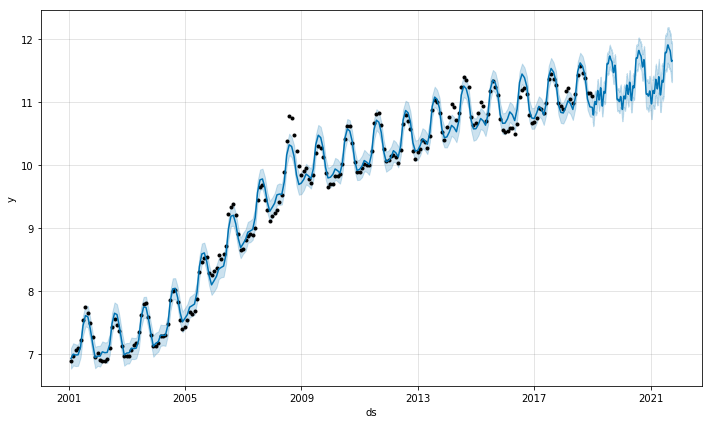

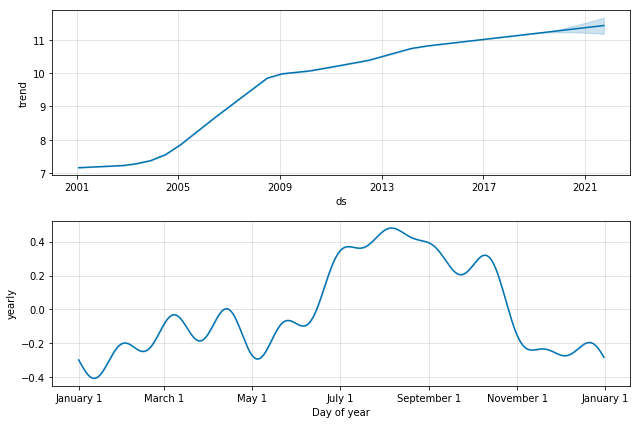

In [28]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [29]:



#Spliting for train and test
test_size=0.1
max_idx_train=round(len(df_y)*(1-test_size))
df_y_train=df_y.iloc[0:max_idx_train,slice(None)]
df_y_test=df_y.iloc[max_idx_train+1:,slice(None)]

df_y_test.tail()

,ds,y
211,2018-08-31,11.460196
212,2018-09-30,11.379608
213,2018-10-31,11.138235
214,2018-11-30,11.138039
215,2018-12-31,11.090588


In [30]:
m2 = Prophet() #Instantiate
m2.add_seasonality(name='yearly', period=365, fourier_order=10) #Parameters
m2.fit(df_y_train)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
forecast = m2.predict(df_y_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
16,2018-08-31,11.406252,11.173991,11.607676
17,2018-09-30,11.243357,11.007978,11.473767
18,2018-10-31,10.827113,10.587847,11.063960
19,2018-11-30,10.661608,10.425725,10.919779
20,2018-12-31,10.689266,10.425845,10.941119


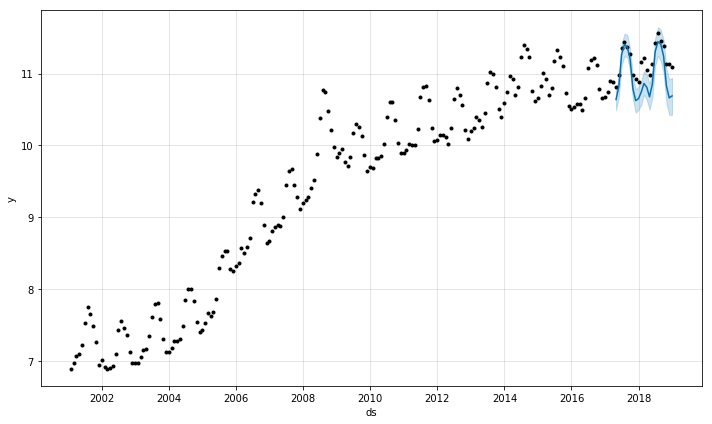

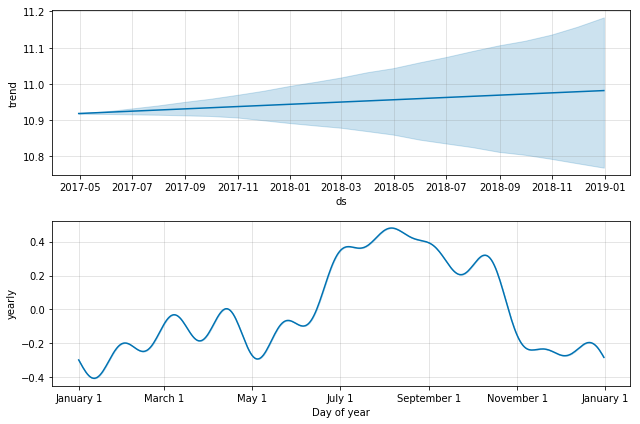

In [34]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)


### Moving Average

In [ ]:
#Estimating Trend
moving_avg=df_monthly_US['Average retail price of electricity'].rolling(12).mean()

In [ ]:
plt.plot(df_monthly_US['date'],df_monthly_US['Average retail price of electricity'], color='blue', label='Actual Data')
plt.plot(df_monthly_US['date'],moving_avg, color='red', label='Estimated Trend')
plt.title('Average retail price of electricity - USA')
plt.ylabel('cts per Killowatt-hour')
plt.legend()
plt.show()

In [ ]:
df_monthly_US['price_without_trend']=df_monthly_US['Average retail price of electricity']-moving_avg
plt.plot(df_monthly_US['date'],df_monthly_US['price_without_trend'], color='red')
plt.title('Average retail price of electricity - USA')
plt.ylabel('cts per Killowatt-hour')
plt.show()

--------------------------------

In [ ]:
idx=df_data.index[(df_data['region']=='East North Central')]
#idx=slice(None)

In [ ]:
#First try removing dates and any other feature different to float type

df_data2=df_data.iloc[idx,[2,4,6,8,10,12,13,14]].copy()
df_data2.dropna(axis=0, inplace=True)
df_data2['Electricity Overhead']=df_data2['Net generation']-df_data2['Retail sales of electricity']
df_data2.head()

In [ ]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
# Create arrays for the features and the response variable
variable="Average retail price of electricity"
y = df_data2[variable].values
X = df_data2.drop(variable, axis=1).values

In [ ]:
#Linear Regresion
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)



In [ ]:
# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


In [ ]:
#Cross Validation
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg_all,X,y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))


In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')
plt.show()


In [ ]:
#feature selection
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X_train, y_train)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

df_columns=df_data2.drop(variable, axis=1).columns
# Plot the coefficients
plt.plot(range(len(df_columns)), lasso_coef)
plt.xticks(range(len(df_columns)), df_columns.values, rotation=90)
plt.title('coeficients - '+variable)
plt.margins(0.02)
plt.show()

In [ ]:
df_columns

In [ ]:
from sklearn.model_selection import TimeSeriesSplit 

In [ ]:
# Create arrays for the features and the response variable
variable="Retail sales of electricity"
y = df_data[variable].values
X = df_data.drop(variable, axis=1).values

In [ ]:
####Checking shape
print('X.shape=',X.shape,'y.shape=',y.shape)

In [ ]:
# Reshape X and y
#y = y.reshape(-1,1)
X = X.reshape(-1,1)
print('X.shape=',X.shape,'y.shape=',y.shape)

In [ ]:
from sklearn.model_selection import TimeSeriesSplitimport 
tscv = TimeSeriesSplit(n_splits=5)
TimeSeriesSplit(n_splits=’warn’, max_train_size=None)

#### Scikit-Learn Estimator Selection

In [ ]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

from sklearn.metrics import make_scorer
root_mean_squared_log_error = make_scorer(rmsle, greater_is_better=False)

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)

In [ ]:
from sklearn.linear_model import LinearRegression  # step 1 - import
lr = LinearRegression()                            # step 2 - instantiate
lr.fit(X, y)                                       # step 3 - fit

lr.score(X, y)
cross_val_score(lr, X, y, cv=kf, scoring=root_mean_squared_log_error)

In [ ]:
# list of ml models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

def get_models(models=dict()):
# linear models
    models['lr'] = LinearRegression()
    models['lasso'] = Lasso()
    models['ridge'] = Ridge()
    models['en'] = ElasticNet()
    models['huber'] = HuberRegressor()
    models['lars'] = Lars()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['ranscac'] = RANSACRegressor()
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    print('Defined %d models' % len(models))
    return models